# Import required dependencies

In [2]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Download necessary NLTK resources


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ziadz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ziadz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ziadz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing Class

In [4]:
class Preprocessing:
    def __init__(self):
        self.sett = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        # Convert to lowercase
        text = text.lower()
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Tokenize
        text = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        text = [self.lemmatizer.lemmatize(word) for word in text if word not in self.sett]
        
        return ' '.join(text)

    def transform(self, X):
        return X.apply(self.clean_text)

# Load and preprocess data


In [ ]:
def load_and_preprocess_data(file_path):
    # Load data
    df = pd.read_csv(file_path)
    
    # Handle missing values
    df.dropna(subset=['text'], inplace=True)
    df.fillna(' ', inplace=True)
    
    # Combine text columns
    df['content'] = df['title'] + ' ' + df['author'] + ' ' + df['text']
    
    # Preprocess
    preprocessor = Preprocessing()
    df['processed_content'] = preprocessor.transform(df['content'])
    
    return df, preprocessor

# Prepare data for deep learning models

In [6]:
def prepare_data(df, max_features=5000, max_len=200):
    # Prepare X and y
    X = df['processed_content']
    y = df['label']
    
    # Tokenize
    tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
    tokenizer.fit_on_texts(X)
    
    # Convert to sequences
    X_seq = tokenizer.texts_to_sequences(X)
    
    # Pad sequences
    X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, tokenizer

# Build RNN Model

In [7]:
def build_rnn_model(max_features, max_len):
    model = Sequential([
        # Embedding layer
        Embedding(max_features, 32, input_length=max_len),
        
        # Simple RNN layer
        SimpleRNN(64, return_sequences=True),
        Dropout(0.5),
        
        SimpleRNN(32),
        Dropout(0.5),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build LSTM Model

In [8]:
def build_lstm_model(max_features, max_len):
    model = Sequential([
        # Embedding layer
        Embedding(max_features, 32, input_length=max_len),
        
        # LSTM layers
        LSTM(64, return_sequences=True),
        Dropout(0.5),
        
        LSTM(32),
        Dropout(0.5),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Train and evaluate model

In [26]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, epochs=10):
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=6, 
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=32, 
        validation_split=0.2, 
        callbacks=[early_stopping]
    )
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
    
    return model, history

# Plotting function


In [18]:
import matplotlib.pyplot as plt

def plot_metrics(history, title):
    # Get metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Execution

In [16]:
# Load and preprocess data
df, preprocessor = load_and_preprocess_data('train.csv')

# Prepare data for deep learning
max_features = 5000
max_len = 200
X_train, X_test, y_train, y_test, tokenizer = prepare_data(
    df, 
    max_features=max_features, 
    max_len=max_len
)

In [ ]:
# Train RNN Model
print("\n--- RNN Model Training ---")
rnn_model = build_rnn_model(max_features, max_len)
trained_rnn_model, rnn_history = train_and_evaluate_model(
    rnn_model, X_train, X_test, y_train, y_test, epochs=10
)


--- RNN Model Training ---
Epoch 1/10
416/416 [==============================] - 121s 283ms/step - loss: 0.7410 - accuracy: 0.5315 - val_loss: 0.6445 - val_accuracy: 0.6448
Epoch 2/10
416/416 [==============================] - 122s 292ms/step - loss: 0.6668 - accuracy: 0.6035 - val_loss: 0.5698 - val_accuracy: 0.7077
Epoch 3/10
416/416 [==============================] - 128s 307ms/step - loss: 0.5230 - accuracy: 0.7530 - val_loss: 0.6688 - val_accuracy: 0.6379
Epoch 4/10
416/416 [==============================] - 126s 302ms/step - loss: 0.3975 - accuracy: 0.8306 - val_loss: 0.3391 - val_accuracy: 0.8648
Epoch 5/10
416/416 [==============================] - 105s 252ms/step - loss: 0.4851 - accuracy: 0.7253 - val_loss: 0.6359 - val_accuracy: 0.6761
Epoch 6/10
416/416 [==============================] - 134s 321ms/step - loss: 0.5807 - accuracy: 0.7110 - val_loss: 0.6126 - val_accuracy: 0.7179
Epoch 7/10
130/130 [==============================] - 4s 34ms/step - loss: 0.3453 - accuracy: 0.

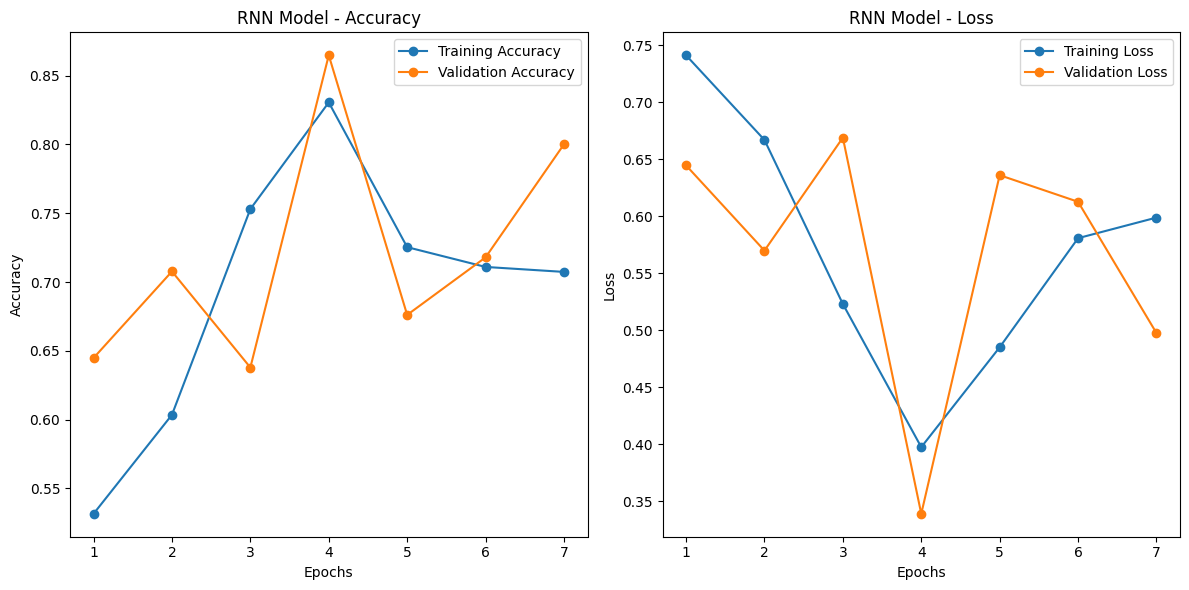

In [19]:
plot_metrics(rnn_history, "RNN Model")

In [27]:
# Train LSTM Model
print("\n--- LSTM Model Training ---")
lstm_model = build_lstm_model(max_features, max_len)
trained_lstm_model, lstm_history = train_and_evaluate_model(
    lstm_model, X_train, X_test, y_train, y_test, epochs=50
)


--- LSTM Model Training ---
Epoch 1/50
416/416 [==============================] - 15s 32ms/step - loss: 0.6369 - accuracy: 0.6264 - val_loss: 0.5150 - val_accuracy: 0.7968
Epoch 2/50
416/416 [==============================] - 13s 31ms/step - loss: 0.4735 - accuracy: 0.8042 - val_loss: 0.4235 - val_accuracy: 0.8627
Epoch 3/50
416/416 [==============================] - 12s 29ms/step - loss: 0.4088 - accuracy: 0.8498 - val_loss: 0.3661 - val_accuracy: 0.8639
Epoch 4/50
416/416 [==============================] - 12s 29ms/step - loss: 0.5877 - accuracy: 0.6806 - val_loss: 0.6334 - val_accuracy: 0.5747
Epoch 5/50
416/416 [==============================] - 13s 30ms/step - loss: 0.5396 - accuracy: 0.7459 - val_loss: 0.3476 - val_accuracy: 0.8895
Epoch 6/50
416/416 [==============================] - 12s 29ms/step - loss: 0.6209 - accuracy: 0.6694 - val_loss: 0.6629 - val_accuracy: 0.6803
Epoch 7/50
416/416 [==============================] - 12s 29ms/step - loss: 0.4871 - accuracy: 0.7974 - val

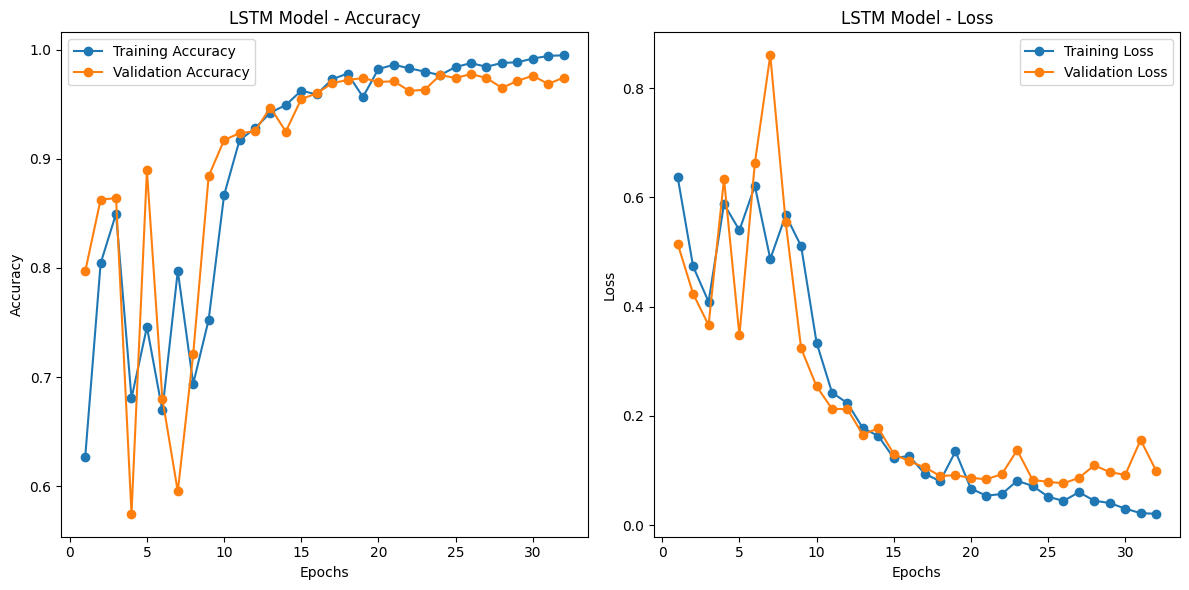

In [28]:
plot_metrics(lstm_history, "LSTM Model")

In [32]:
# Save models and preprocessing tools
trained_rnn_model.save('models/rnn_model')
trained_lstm_model.save('models/lstm_model')

# Save histories and preprocessing tools
with open('models/rnn_history.pkl', 'wb') as f:
    pickle.dump(rnn_history.history, f)
    
with open('models/lstm_history.pkl', 'wb') as f:
    pickle.dump(lstm_history.history, f)
    
with open('models/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
    
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

INFO:tensorflow:Assets written to: models/rnn_model\assets


INFO:tensorflow:Assets written to: models/rnn_model\assets


INFO:tensorflow:Assets written to: models/lstm_model\assets


INFO:tensorflow:Assets written to: models/lstm_model\assets


# Example prediction function


In [30]:
def predict_text(text, model, preprocessor, tokenizer, max_len=200):
    # Preprocess the text
    processed_text = preprocessor.transform(pd.Series(text))
    
    # Tokenize and pad
    text_seq = tokenizer.texts_to_sequences(processed_text)
    text_padded = pad_sequences(text_seq, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(text_padded)
    return 1 if prediction[0][0] > 0.5 else 0

In [31]:
# Test prediction
test_text = 'israel invaded rafa and killed 10 people'
print("\n--- Example Prediction ---")
print("RNN Model Prediction:", predict_text(
    test_text, trained_rnn_model, preprocessor, tokenizer
))
print("LSTM Model Prediction:", predict_text(
    test_text, trained_lstm_model, preprocessor, tokenizer
))


--- Example Prediction ---
1/1 [==============================] - 0s 255ms/step
RNN Model Prediction: 1
1/1 [==============================] - 0s 435ms/step
LSTM Model Prediction: 1
